# Solving the number partitioning problem using OpenQAOA

## The combinatorial problem

Number partitioning is often considerest the simplest among NP-Hard combinatorial optimisation problems (see [wikipedia](https://en.wikipedia.org/wiki/Partition_problem) for a simple reference). The problem statement is quite simple: you are given a set of numbers $N$ where $n_i \in N$ is a positive integer, and you are asked to find two subsets $A$ and $B$ such that

1. $A \cap B = \emptyset$, i.e., the two sets are disjoint
2. $|\sum_i a_i - \sum_j b_j|$, where $ a \in A$ and $b \in B$ is minimised, i.e., the difference in the sum of all elements in A and the sum of all the elements in B is minimised

Now, QAOA only accepts binary terms. However, we are in luck! There is a straightforward formulation of the above problem statement in binary variables. And it is already implemented in OpenQAOA! :)

\begin{equation}
\verb|Cost function| = (\sum_i n_i x_i)^2
\end{equation}

where each $x_i \in \pm 1$ is a binary decisional variable, and $n_i$ is the i-th number in the list

Let's make a concrete case. Let's assume we want to partition the simples problem we can think of: $N = [1,2,3]$.

Then our cost function will be

\begin{equation}
\verb|Cost function| = (1*x_1 + 2*x_2 + 3*x_3)^2
\end{equation}

Now, our algorithm has to find a set of values $verb|solution| = (x_1, x_2, x_3)$ such that the cost function above is minimised.

For this problem, you can verify that solutions $1,1,0$ and $0, 1, 1$ indeed solve the problem!

# Let's solve the problem with OpenQAOA

### The very first step is the problem creation

In [1]:
from openqaoa.problems.problem import NumberPartition
np = NumberPartition(numbers=[1,2,3])
np_qubo = np.get_qubo_problem()

You can visualise the problem statement as

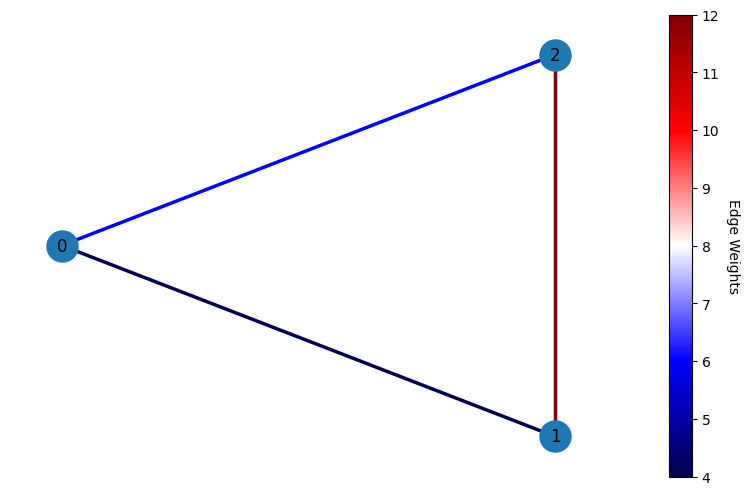

In [2]:
# visualize the QUBO form on a graph
from openqaoa.utilities import plot_graph, graph_from_hamiltonian

#extract Hamiltonain
cost_hamil = np_qubo.hamiltonian

#convert Hamiltonian to graph
cost_gr = graph_from_hamiltonian(cost_hamil)

#plot the graph
plot_graph(cost_gr)

### Now, let's solve the problem using OpenQAOA

In [3]:
from openqaoa.workflows.optimizer import QAOA

The simples QAOA workflow you can crate is the following

In [4]:
# Initialise QAOA using the default values
q = QAOA()
# Complile the QAOA workflow
q.compile(np_qubo)
# Optimise the problem!
q.optimize()

states kept: 8


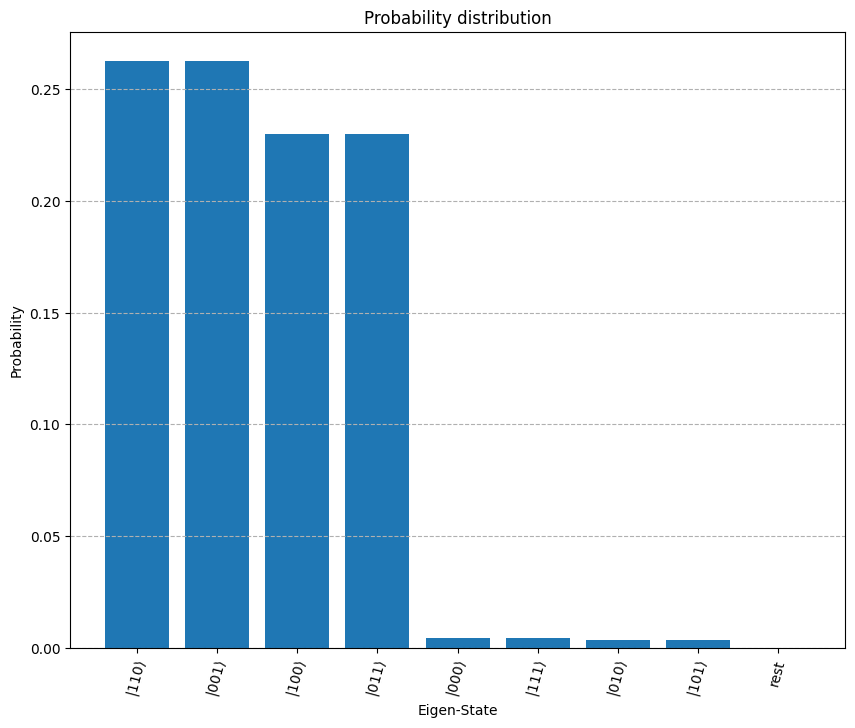

In [5]:
q.results.plot_probabilities()

Yay! Indeed the two states with the highes probabilities are `110` and `110`

## Setting up the initial parmeters

Let's try to set the initial parameters for OpenQAOA

In [6]:
# Initialise QAOA
q = QAOA()
q.compile(np_qubo)

After compiling the problem, OpenQAOA generates and initialises the value of the variational parameters:

In [7]:
q.variate_params

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [0.35]
	gammas: [0.35]

However, as problems get more and more complex it gets hardwre and harder to select good parameters. In OpenQAOA we have three strategies controlled by the keywordk `init_type`:

1. Random
2. Custom
3. (linear) Ramp

In [8]:
# Initialise QAOA
q = QAOA()
q.set_circuit_properties(p=1, param_type='standard', init_type='rand')
q.compile(np_qubo)

In [9]:
q.variate_params

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [1.93582059]
	gammas: [1.89987175]

## The challenge

You have to find a good way to initialise the variational parameters!

In [10]:
import numpy
def my_submission_function(p):
    """
    Note that the number of betas and gammas depend on the number of layers `p`!

    Also, in OpenQAOA there are several parametrisation techiques which will change the structure 
    of the return of `my_submission_function`
    For more details: https://el-openqaoa.readthedocs.io/en/latest/notebooks/05_advanced_parameterization.html
    """
    
    return { 'betas'  : [numpy.random.randn() for i in range(p)],
             'gammas' : [numpy.random.randn() for i in range(p)]}

In [11]:
p = 2
q_submission = QAOA()
q_submission.set_circuit_properties(p=p, 
                                    param_type='standard',
                                    init_type='custom',
                                    variational_params_dict=my_submission_function(2))

In [12]:
my_submission_function(2)

{'betas': [0.7316421680955091, -0.9978591620001178],
 'gammas': [0.16723487316407012, -0.6871404307086166]}

In [13]:
q_submission.compile(np_qubo)

In [14]:
q_submission.optimize()

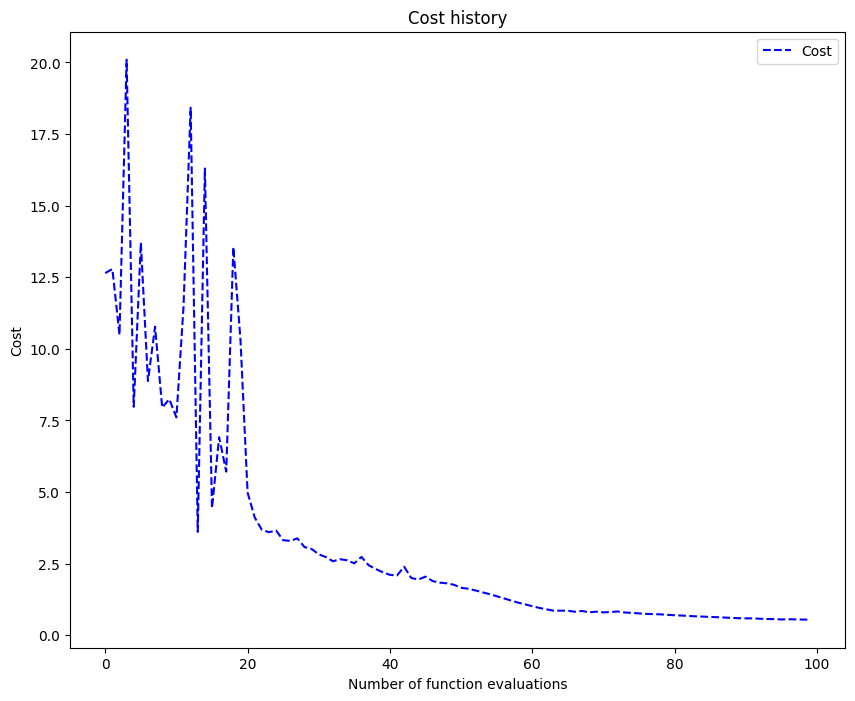

In [15]:
q_submission.results.plot_cost()

states kept: 8


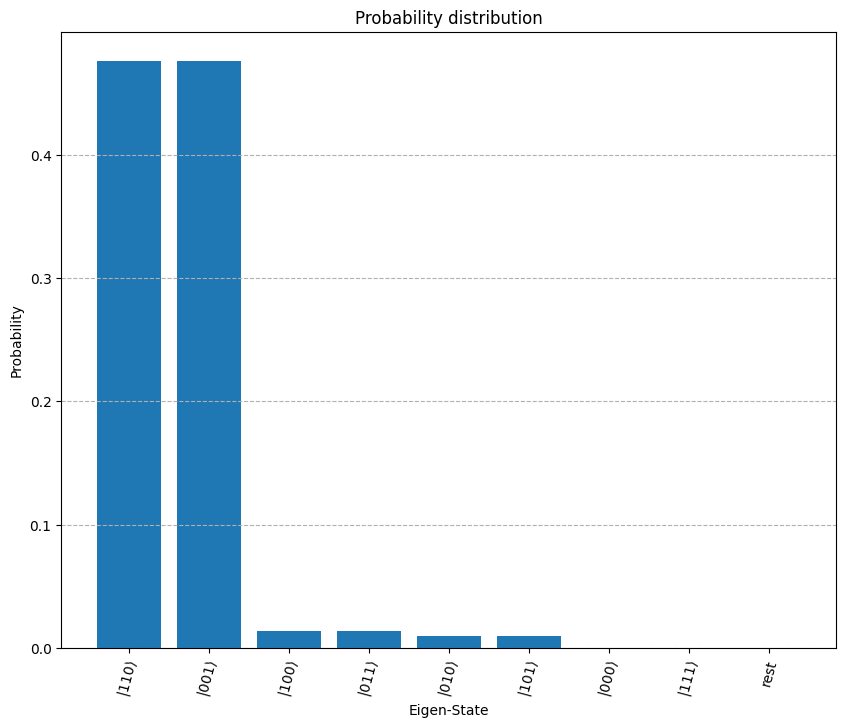

In [16]:
q_submission.results.plot_probabilities()

## Data generation

To generate data for the number partitioning problem simple generate lists of 10 random numbers between 1 and 30. For example,

In [18]:
np_input = [numpy.random.randint(30) for i in range(10)]
np_input

[29, 4, 1, 24, 22, 29, 4, 29, 13, 9]